In [12]:
!pip install torch
!pip install torchvision

In [0]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.nn import init
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch import distributions as D

from itertools import cycle
from functools import reduce
from operator import __or__
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [0]:
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import sys
import math

from IPython import display

In [15]:
epochs=10
use_cuda = torch.cuda.is_available()
seed=1
torch.manual_seed(seed)

### Utils

In [0]:
def onehot(k):
    def encode(label):
        y = torch.zeros(k)
        if label < k:
            y[label] = 1
        return y
    return encode

def get_mnist(location="../data", batch_size=64, labels_per_class=100, n_labels=10):

    flatten_bernoulli = lambda x: transforms.ToTensor()(x).view(-1).bernoulli()

    mnist_train = MNIST(location, train=True, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))
    mnist_valid = MNIST(location, train=False, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))

    def get_sampler(labels, n=None):
        # Only choose digits in n_labels
        (indices,) = np.where(reduce(__or__, [labels == i for i in np.arange(n_labels)]))

        # Ensure uniform distribution of labels
        np.random.shuffle(indices)
        indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in range(n_labels)])

        indices = torch.from_numpy(indices)
        sampler = SubsetRandomSampler(indices)
        return sampler

    # Dataloaders for MNIST
    labelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2, pin_memory=use_cuda,
                                           sampler=get_sampler(mnist_train.train_labels.numpy(), labels_per_class))
    unlabelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2, pin_memory=use_cuda,
                                             sampler=get_sampler(mnist_train.train_labels.numpy()))
    validation = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, num_workers=2, pin_memory=use_cuda,
                                             sampler=get_sampler(mnist_valid.test_labels.numpy()))

    return labelled, unlabelled, validation

### Model

In [0]:
class M2(nn.Module):
  def __init__(self, x_dim=784, y_dim=10, z_dim=32, 
                     h_en_dim=[256, 128], h_de_dim=[128, 256], 
                     h_cls_dim=256):
    super(M2, self).__init__()

    self.x_dim = x_dim
    self.y_dim = y_dim
    self.z_dim = z_dim

    en_neurons = [x_dim + y_dim, *h_en_dim]
    de_neurons = [y_dim + z_dim, *h_de_dim]

    en_linear_layers = [nn.Linear(en_neurons[i-1], en_neurons[i]) for i in range(1, len(en_neurons))]
    de_linear_layers = [nn.Linear(de_neurons[i-1], de_neurons[i]) for i in range(1, len(de_neurons))]

    # For encoder - q(z|x,y)
    self.en_hidden = nn.ModuleList(en_linear_layers)
    self.mu = nn.Linear(h_en_dim[-1], z_dim)
    self.log_var = nn.Linear(h_en_dim[-1], z_dim)

    # For decoder - p(x|y,z)
    self.de_hidden = nn.ModuleList(de_linear_layers)
    self.reconstruction = nn.Linear(h_de_dim[-1], x_dim)

    # For classifier - q(y|x)
    self.cls_hidden = nn.Linear(x_dim, h_cls_dim)
    self.logits = nn.Linear(h_cls_dim, y_dim)

  def encode(self, x, y):
    h = torch.cat([x, y], dim=1)
    for layer in self.en_hidden:
        h = F.relu(layer(h))

    mu = self.mu(h)
    log_var = F.softplus(self.log_var(h))

    return self.reparameterize(mu, log_var), mu, log_var

  def reparameterize(self, mu, logvar):
    eps = Variable(torch.randn(mu.size()))
    if mu.is_cuda:
        eps = eps.cuda()

    std = torch.exp(0.5*logvar)
    return mu + eps*std

  def decode(self, y, z):
    h = torch.cat([y, z], dim=1)
    for layer in self.de_hidden:
        h = F.relu(layer(h))
    return torch.sigmoid(self.reconstruction(h))

  def classify(self, x, apply_softmax=True):
    x = F.relu(self.cls_hidden(x))
    logits = self.logits(x)
    if not apply_softmax:
      return logits
    probs = F.softmax(logits, dim=-1)
    return probs

  def sample(self, y, z):
    y = y.float()
    x = self.decode(y, z)
    return x

  # Calculating ELBO (Both labelled or unlabelled)
  def forward(self, x, y=None):
    labelled = False if y is None else True

    xs, ys = (x, y)
    # Duplicating samples and generate labels if not labelled
    if not labelled:
      batch_size = xs.size(0)
      ys = torch.from_numpy(np.arange(self.y_dim))
      ys = ys.view(-1,1).repeat(1, batch_size).view(-1)
      ys = F.one_hot(ys, self.y_dim)
      ys = Variable(ys.float())
      ys = ys.cuda() if xs.is_cuda else ys
      xs = xs.repeat(self.y_dim, 1)
    
    # Reconstruction
    zs, z_mu, z_log_var = self.encode(xs, ys)
    x_theta = self.decode(ys, zs)

    # p(x|y,z)
    loglikelihood = torch.sum(xs * torch.log(x_theta + 1e-8) + (1 - xs) 
                                 * torch.log(1 - x_theta + 1e-8), dim=-1)

    # p(y)
    logprior_y = -math.log(self.y_dim)

    # KL(q(z|x,y)||p(z))
    p_z = D.normal.Normal(torch.zeros_like(zs), torch.ones_like(zs))
    p_z = D.independent.Independent(p_z, 1)
    q_z = D.normal.Normal(z_mu, torch.exp(0.5*z_log_var))
    q_z = D.independent.Independent(q_z, 1)
    kl = D.kl.kl_divergence(q_z, p_z)

    # ELBO : -L(x,y)
    neg_L = loglikelihood + logprior_y - kl

    if labelled:
      return torch.mean(neg_L)

    prob_y = self.classify(x)

    neg_L = neg_L.view_as(prob_y.t()).t()

    # H(q(y|x)) and sum over all labels
    H = -torch.sum(torch.mul(prob_y, torch.log(prob_y + 1e-8)), dim=-1)
    neg_L = torch.sum(torch.mul(prob_y, neg_L), dim=-1)

    # ELBO : -U(x)
    neg_U = neg_L + H
    return torch.mean(neg_U)

In [0]:
x_dim=784 
y_dim=10 
z_dim=32
h_en_dim=[256, 128]
h_de_dim=[128, 256]
h_cls_dim=256

model = M2(x_dim, y_dim, z_dim, h_en_dim, h_de_dim, h_cls_dim)

In [19]:
# Only use 10 labelled examples per class
# The rest of the data is unlabelled.
labelled, unlabelled, validation = get_mnist(location="../data", batch_size=64, labels_per_class=10)
alpha = 0.1 * len(unlabelled) / len(labelled)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))
if use_cuda: model = model.cuda()

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [0]:
def train(epoch):
  model.train()
  total_loss, accuracy = (0, 0)
  for (x, y), (u, _) in zip(cycle(labelled), unlabelled):
    optimizer.zero_grad()
    # Wrap in variables
    x, y, u = Variable(x), Variable(y), Variable(u)

    if use_cuda:
      x, y = x.cuda(), y.cuda()
      u = u.cuda()

    L = -model(x, y)
    U = -model(u)

    # Add auxiliary classification loss q(y|x)
    prob_y = model.classify(x)
    
    # cross entropy
    classication_loss = -torch.sum(y * torch.log(prob_y + 1e-8), dim=1).mean()

    J_alpha = L + U + alpha * classication_loss

    J_alpha.backward()
    optimizer.step()
    
    total_loss += J_alpha.item()
    accuracy += torch.mean((torch.max(prob_y, 1)[1].data == torch.max(y, 1)[1].data).float()).item()

  display.clear_output(wait=False)
  m = len(unlabelled)
  print("Epoch: {}".format(epoch))
  print("[Train]\t\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))
  return total_loss / m, accuracy / m


def test(epoch):

  model.eval()

  total_loss, accuracy = (0, 0)
  
  for x, y in validation:
    x, y = Variable(x), Variable(y)

    if use_cuda:
      x, y = x.cuda(), y.cuda()

    L = -model(x, y)
    U = -model(x)

    prob_y = model.classify(x)
    classication_loss = -torch.sum(y * torch.log(prob_y + 1e-8), dim=1).mean()

    J_alpha = L + U + alpha * classication_loss

    total_loss += J_alpha.item()

    _, pred_idx = torch.max(prob_y, 1)
    _, lab_idx = torch.max(y, 1)
    accuracy += torch.mean((pred_idx == lab_idx).float()).item()

  m = len(validation)
  print("[Validation]\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))
  return total_loss / m, accuracy / m


def draw_samples(n=10, d=7):
  model.eval()
  z = Variable(torch.randn(16, 32))

  # Generate a set of digit 'd'
  y = Variable(onehot(10)(d).repeat(16, 1))

  if use_cuda:
      z, y = z.cuda(), y.cuda()

  x_mu = model.sample(y, z)
  samples = x_mu.data.view(-1, 28, 28).cpu().numpy()

  plt.figure(figsize=(10, 10))
  for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(np.reshape(samples[i], (28,28)),
                interpolation="None",
                cmap='gray')
    plt.axis('off')
  plt.show()  

Epoch: 10
[Train]		 J_a: 203.11, accuracy: 1.00
[Validation]	 J_a: 324.50, accuracy: 0.86


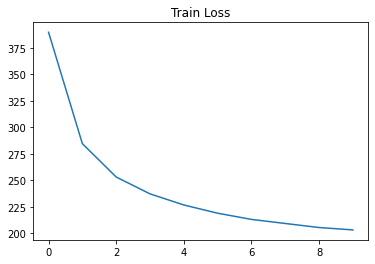

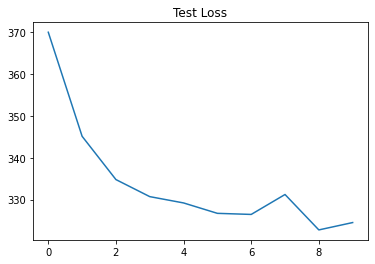

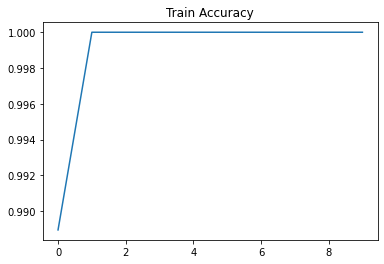

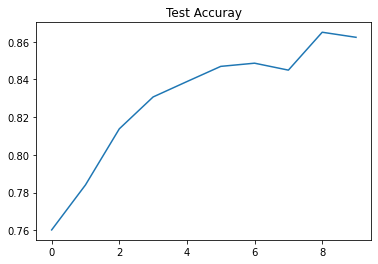

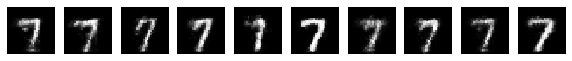

In [21]:
train_loss=[]
test_loss=[]

train_accuracy=[]
test_accuracy=[]

for epoch in range(1, epochs + 1):
    train_l, train_acc = train(epoch)
    test_l, test_acc = test(epoch)

    train_loss.append(train_l)
    test_loss.append(test_l)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

    plt.title('Train Loss')
    plt.plot(train_loss)
    plt.show()

    plt.title('Test Loss')
    plt.plot(test_loss)
    plt.show()

    plt.title('Train Accuracy')
    plt.plot(train_accuracy)
    plt.show()

    plt.title('Test Accuray')
    plt.plot(test_accuracy)
    plt.show()

    draw_samples()

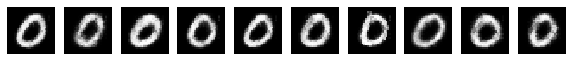

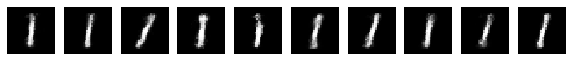

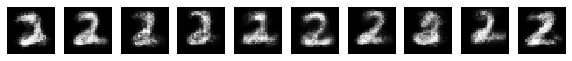

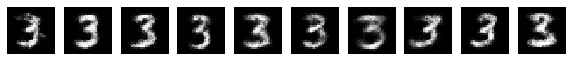

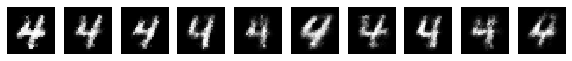

In [22]:
draw_samples(d=0)
draw_samples(d=1)
draw_samples(d=2)
draw_samples(d=3)
draw_samples(d=4)